# Import libraries

Stream data from [Dandiset 53](https://dandiarchive.org/dandiset/000053?search=000053&pos=1) "Recordings from medial entorhinal cortex during linear track and open exploration" from [Mallory et al., 2021](https://www.nature.com/articles/s41467-021-20936-8).

In [1]:
import h5py
import pathlib
import remfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap
import pandas as pd

nap.nap_config.set_backend("jax")
warnings.filterwarnings('ignore')

from scipy.stats import zscore
from dandi.download import download
from dandi.dandiapi import DandiAPIClient
from pynwb import NWBHDF5IO

# Stream the data using remfile

In [2]:
dandiset_id = '000053'
filepath = "sub-npJ5/sub-npJ5_ses-20190505_obj-10plzqh_behavior+ecephys.nwb"
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

In [3]:
rem_file = remfile.File(s3_url)

file = h5py.File(rem_file, "r")
io = NWBHDF5IO(file=file)
nwbfile = io.read()

In [4]:
nwbfile

,x,y,z,imp,location,filtering,group,group_name,shank_electrode_number,rel_x,rel_y
id,,,,,,,,,,,
0,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136\nFields:\n description: Shank1 electrodes.\n device: Device pynwb.device.Device at 0x6073702720\nFields:\n description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!\n\n location: unknown\n,Shank1,0,0.0,0.0
1,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136\nFields:\n description: Shank1 electrodes.\n device: Device pynwb.device.Device at 0x6073702720\nFields:\n description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!\n\n location: unknown\n,Shank1,1,16.0,0.0
2,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136\nFields:\n description: Shank1 electrodes.\n device: Device pynwb.device.Device at 0x6073702720\nFields:\n description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!\n\n location: unknown\n,Shank1,2,0.0,20.0
3,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136\nFields:\n description: Shank1 electrodes.\n device: Device pynwb.device.Device at 0x6073702720\nFields:\n description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!\n\n location: unknown\n,Shank1,3,16.0,20.0
,x,y,z,imp,location,filtering,group,group_name,shank_electrode_number,rel_x,rel_y
id,,,,,,,,,,,
0,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136\nFields:\n description: Shank1 electrodes.\n device: Device pynwb.device.Device at 0x6073702720\nFields:\n description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!\n\n location: unknown\n,Shank1,0,0.0,0.0
1,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136\nFields:\n description: Shank1 electrodes.\n device: Device pynwb.device.Device at 0x6073702720\nFields:\n description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!\n\n location: unknown\n,Shank1,1,16.0,0.0
2,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136\nFields:\n description: Shank1 electrodes.\n device: Device pynwb.device.Device at 0x6073702720\nFields:\n description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!\n\n location: unknown\n,Shank1,2,0.0,20.0


# Identify MEC units
In the Giocomo lab dataset, we think all units are in MEC, but in some datasets there may be recordings from multiple brain regions and we want to select by individual brain region

In [5]:
electrodes_df = nwbfile.electrodes.to_dataframe()
electrodes_df

,x,y,z,imp,location,filtering,group,group_name,shank_electrode_number,rel_x,rel_y
id,,,,,,,,,,,
0,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,0,0.0,0.0
1,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,1,16.0,0.0
2,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,2,0.0,20.0
3,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,3,16.0,20.0
4,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,4,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
379,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,379,16.0,3780.0
380,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,380,0.0,3800.0
381,NaN,NaN,NaN,-1.0,unknown,none,Shank1 pynwb.ecephys.ElectrodeGroup at 0x60737...,Shank1,381,16.0,3800.0


In [6]:
# if location information is provided, select the appropriate probe group for analysis
select_MEC = np.any(["MEC" in location for location in electrodes_df['location'].unique()])
select_MEC

if select_MEC:
    mec_group = electrodes_df.query("'MEC' in location")["group"][0]
else:
    mec_group = electrodes_df['group'].unique()[0]
mec_group

Shank1 pynwb.ecephys.ElectrodeGroup at 0x6073707136
Fields:
  description: Shank1 electrodes.
  device: Device pynwb.device.Device at 0x6073702720
Fields:
  description: More details for the high-pass (ap) data found in npJ5_0505_contrast_g0_imec0.ap.meta!

  location: unknown

In [7]:
# load the units information as a dataframe
units_df = nwbfile.units.to_dataframe()
units_df

,spike_times
id,
1,"[0.4840533805936502, 0.6823533805927582, 3.711..."
2,"[9.98735338059305, 11.572220047260089, 12.3448..."
3,"[20.19578671392628, 27.551820047259753, 27.738..."
4,"[0.5689200472597804, 7.186586713926772, 12.356..."
5,"[0.04055338059333735, 0.05798671392676624, 0.0..."
...,...
385,"[0.04085338059303467, 0.06045338059357164, 0.0..."
386,"[0.014020047259691637, 0.08562004725990846, 0...."
387,"[0.04168671392653778, 0.062053380593170004, 0...."


In [8]:
# select units based on electrode group and quality metrics
if 'cluster_quality' in units_df.columns:
    mec_units = units_df.query(f'electrode_group == {mec_group} & cluster_quality == "good"')
elif 'electrode_group' in units_df.columns:
    mec_units = units_df.query(f'electrode_group == {mec_group}') # TODO - double check this works still
else:
    mec_units = units_df
mec_units

,spike_times
id,
1,"[0.4840533805936502, 0.6823533805927582, 3.711..."
2,"[9.98735338059305, 11.572220047260089, 12.3448..."
3,"[20.19578671392628, 27.551820047259753, 27.738..."
4,"[0.5689200472597804, 7.186586713926772, 12.356..."
5,"[0.04055338059333735, 0.05798671392676624, 0.0..."
...,...
385,"[0.04085338059303467, 0.06045338059357164, 0.0..."
386,"[0.014020047259691637, 0.08562004725990846, 0...."
387,"[0.04168671392653778, 0.062053380593170004, 0...."


In [9]:
# create the pynapple object
selected_unit_indices = range(len(mec_units))
mec_tsgroup = nap.TsGroup({i: nap.Ts(units_df["spike_times"][i]) for i in units_df.index[selected_unit_indices]})
mec_tsgroup

Index    rate
-------  --------
1        2.61439
2        0.31042
3        0.29918
4        0.81883
5        41.27495
6        0.4561
7        2.92921
...      ...
383      0.21803
384      40.83009
385      45.66681
386      37.36411
387      36.43627
388      49.57374
389      52.30985

In [10]:
# restrict by epochs
if nwbfile.epochs is not None:
    epochs = nwbfile.epochs.to_dataframe()
    wheel_start = epochs[epochs["task"] == "Wheel-HeadFixed"]["start_time"].item()
    wheel_end = epochs[epochs["task"] == "Wheel-HeadFixed"]["stop_time"].item()
    mec_tsgroup = mec_tsgroup.restrict(nap.IntervalSet(start=wheel_start, end=wheel_end))

# Preprocess the data

In [57]:
# bin the data 
binsize = 0.120  # seconds
kernel_size = 5  # std
spikes_binned = mec_tsgroup.count(binsize)

# smooth the data
spikes_smoothed = spikes_binned.smooth(std=kernel_size)

# binarize each spike train
spikes_binarized = np.zeros(spikes_smoothed.shape[::-1])
for i, unit in enumerate(spikes_smoothed.columns):
    cond = spikes_smoothed.loc[unit] >= (np.mean(spikes_smoothed.loc[unit]) + np.std(spikes_smoothed.loc[unit]))
    spikes_binarized[i,:] = cond.as_array().astype(int)

# get data in terms of spike times for pynapple autocorrelogram function
samprate = 1 / binsize
spike_times = [[i / samprate for i, val in enumerate(unit) if val == 1] for unit in spikes_binarized] 
mec_tsgroup_processed = nap.TsGroup({i: nap.Ts(unit_data) for i, unit_data in enumerate(spike_times)})
mec_tsgroup_processed

Index    rate
-------  -------
0        1.17085
1        0.80811
2        0.68491
3        1.24565
4        1.4192
5        1.2432
6        1.36933
...      ...
382      0.47518
383      1.32729
384      1.21632
385      1.17232
386      1.80345
387      1.25543
388      1.21925

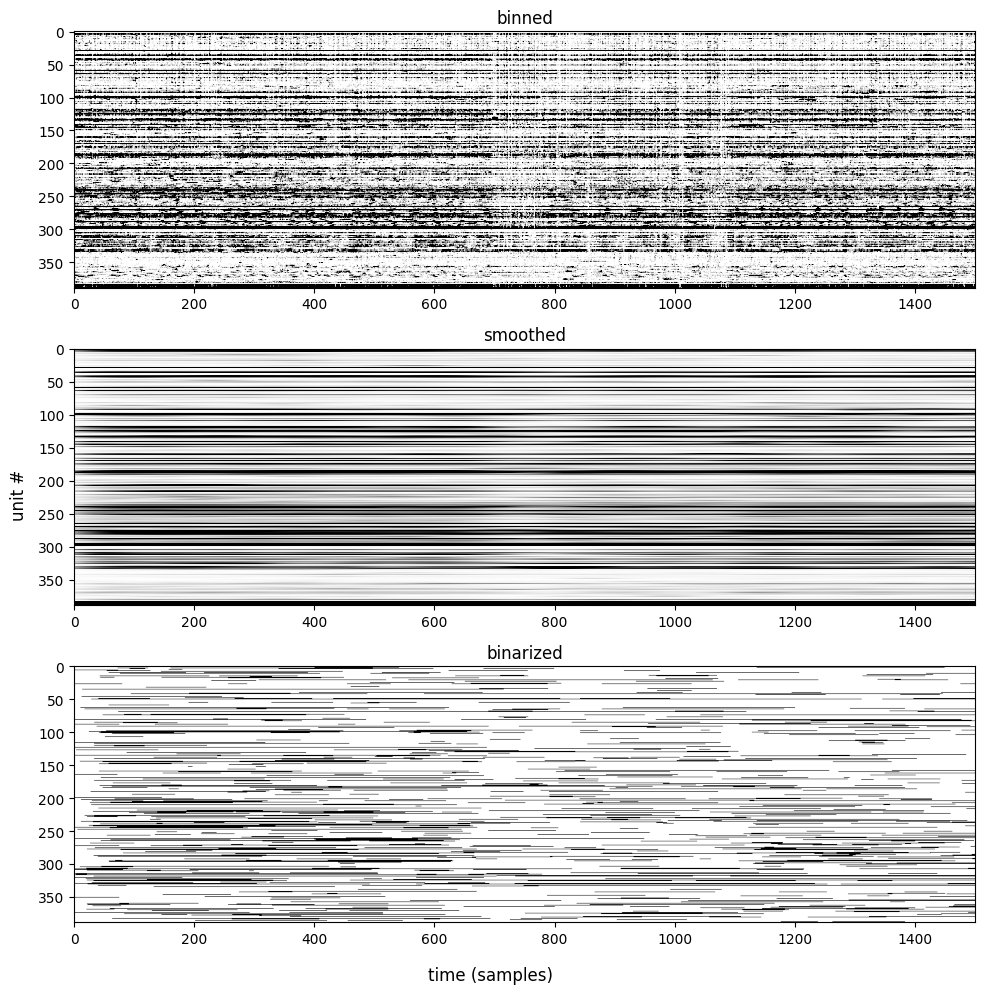

In [56]:
# plot the data preprocessing steps
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

axes[0].imshow(spikes_binned.values.T, aspect='auto', vmin=0, vmax=2, cmap='Greys')
axes[0].set(title="binned", xlim=[0, 1500])
axes[1].imshow(spikes_smoothed.values.T, aspect='auto', vmin=0, vmax=2, cmap='Greys')
axes[1].set(title="smoothed", xlim=[0, 1500])
axes[2].imshow(spikes_binarized, aspect='auto', vmin=0, vmax=1, cmap='Greys')
axes[2].set(title="binarized", xlim=[0, 1500])
fig.supxlabel('time (samples)')
fig.supylabel('unit #')

fig.tight_layout()

# Calculate the autocorrelograms using pynapple

In [58]:
def my_compute_autocorrelogram(
    group, binsize, windowsize, time_units="s"
):
    newgroup = group
    autocorrs = {}

    binsize = nap.TsIndex.format_timestamps(
        np.array([binsize], dtype=np.float64), time_units
    )[0]
    windowsize = nap.TsIndex.format_timestamps(
        np.array([windowsize], dtype=np.float64), time_units
    )[0]

    for n in newgroup.keys():
        spk_time = newgroup[n].index
        auc, times = nap.process.correlograms._cross_correlogram(spk_time, spk_time, binsize, windowsize)
        autocorrs[n] = pd.Series(index=np.round(times, 6), data=auc, dtype="float")

    autocorrs = pd.DataFrame.from_dict(autocorrs)

    # DO NOT normalize
    # DO NOT zero out the center

    return autocorrs.astype("float")

In [59]:
# compute the autocorrelogram for each unit using the processed data
acorr = my_compute_autocorrelogram(mec_tsgroup_processed, binsize=binsize, windowsize=560)
acorr

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
-559.92,0.880306,0.0,0.0,0.909210,0.536801,0.822519,1.187076,0.490630,0.876851,0.267754,...,0.0,0.362013,0.248227,0.0,0.813382,1.507235,0.816653,1.457034,0.830737,0.273991
-559.80,0.887265,0.0,0.0,0.912480,0.542542,0.825796,1.187076,0.494319,0.880099,0.267754,...,0.0,0.362013,0.257092,0.0,0.810313,1.507235,0.816653,1.457034,0.821002,0.273991
-559.68,0.894224,0.0,0.0,0.915751,0.548283,0.829073,1.187076,0.498008,0.883346,0.267754,...,0.0,0.362013,0.265957,0.0,0.807244,1.507235,0.816653,1.457034,0.811267,0.273991
-559.56,0.901183,0.0,0.0,0.919021,0.551154,0.832350,1.187076,0.501697,0.886594,0.267754,...,0.0,0.362013,0.274823,0.0,0.804174,1.507235,0.816653,1.457034,0.801532,0.273991
-559.44,0.908142,0.0,0.0,0.922292,0.554025,0.835627,1.187076,0.505386,0.889842,0.267754,...,0.0,0.362013,0.283688,0.0,0.801105,1.510584,0.820128,1.457034,0.791796,0.273991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559.44,0.908142,0.0,0.0,0.922292,0.554025,0.835627,1.187076,0.505386,0.889842,0.267754,...,0.0,0.362013,0.283688,0.0,0.801105,1.510584,0.820128,1.457034,0.791796,0.273991
559.56,0.901183,0.0,0.0,0.919021,0.551154,0.832350,1.187076,0.501697,0.886594,0.267754,...,0.0,0.362013,0.274823,0.0,0.804174,1.507235,0.816653,1.457034,0.801532,0.273991
559.68,0.894224,0.0,0.0,0.915751,0.548283,0.829073,1.187076,0.498008,0.883346,0.267754,...,0.0,0.362013,0.265957,0.0,0.807244,1.507235,0.816653,1.457034,0.811267,0.273991
559.80,0.887265,0.0,0.0,0.912480,0.542542,0.825796,1.187076,0.494319,0.880099,0.267754,...,0.0,0.362013,0.257092,0.0,0.810313,1.507235,0.816653,1.457034,0.821002,0.273991


## Normalize and sort by power spectra

In [60]:
# convert to corr coeff and z-score each autocorrelogram
acorr_zscored = acorr.copy(deep=True)
acorr_coeff = acorr.copy(deep=True)
for i in acorr:
    acorr_coeff[i].values[:] = acorr[i].values / np.max(acorr[i].values)
    acorr_zscored[i].values[:] = zscore(acorr_coeff[i].values[:])
    # acorr_zscored[i].values[:] = acorr_coeff[i].values[:]

In [61]:
acorr_zscored

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
-559.92,-0.132893,-0.929501,-0.76412,-0.293211,-1.119574,-0.196119,-0.360244,-0.712176,-0.728342,-0.480316,...,-0.611036,-0.878841,-0.676884,-0.647044,-0.456492,0.193924,-0.311109,-1.214122,-0.630963,-1.502158
-559.80,-0.126322,-0.929501,-0.76412,-0.290008,-1.113425,-0.192481,-0.360244,-0.707293,-0.724097,-0.480316,...,-0.611036,-0.878841,-0.665996,-0.647044,-0.459503,0.193924,-0.311109,-1.214122,-0.642643,-1.502158
-559.68,-0.119751,-0.929501,-0.76412,-0.286804,-1.107276,-0.188842,-0.360244,-0.702409,-0.719852,-0.480316,...,-0.611036,-0.878841,-0.655109,-0.647044,-0.462515,0.193924,-0.311109,-1.214122,-0.654324,-1.502158
-559.56,-0.113180,-0.929501,-0.76412,-0.283601,-1.104202,-0.185204,-0.360244,-0.697526,-0.715607,-0.480316,...,-0.611036,-0.878841,-0.644221,-0.647044,-0.465527,0.193924,-0.311109,-1.214122,-0.666005,-1.502158
-559.44,-0.106609,-0.929501,-0.76412,-0.280397,-1.101127,-0.181565,-0.360244,-0.692642,-0.711362,-0.480316,...,-0.611036,-0.878841,-0.633334,-0.647044,-0.468539,0.197345,-0.306716,-1.214122,-0.677685,-1.502158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559.44,-0.106609,-0.929501,-0.76412,-0.280397,-1.101127,-0.181565,-0.360244,-0.692642,-0.711362,-0.480316,...,-0.611036,-0.878841,-0.633334,-0.647044,-0.468539,0.197345,-0.306716,-1.214122,-0.677685,-1.502158
559.56,-0.113180,-0.929501,-0.76412,-0.283601,-1.104202,-0.185204,-0.360244,-0.697526,-0.715607,-0.480316,...,-0.611036,-0.878841,-0.644221,-0.647044,-0.465527,0.193924,-0.311109,-1.214122,-0.666005,-1.502158
559.68,-0.119751,-0.929501,-0.76412,-0.286804,-1.107276,-0.188842,-0.360244,-0.702409,-0.719852,-0.480316,...,-0.611036,-0.878841,-0.655109,-0.647044,-0.462515,0.193924,-0.311109,-1.214122,-0.654324,-1.502158
559.80,-0.126322,-0.929501,-0.76412,-0.290008,-1.113425,-0.192481,-0.360244,-0.707293,-0.724097,-0.480316,...,-0.611036,-0.878841,-0.665996,-0.647044,-0.459503,0.193924,-0.311109,-1.214122,-0.642643,-1.502158


In [62]:
# sort by power value
from scipy import signal

# calculate power value
# nperseg should be power of 2 close to the number of bins in 17.6 minutes (used by their paper)
nperseg = 8196  # 17.6*60/0.120 = 8800
Pxxs = np.zeros((len(acorr_zscored.keys()), int(nperseg/2+1)))
Fs = 1/binsize
for i, key in enumerate(acorr_coeff.keys()):
    f, Pxxs[i,:] = signal.welch(acorr_zscored[key].values, Fs, window="hamming", nperseg=nperseg)

# get sorting index
ind = np.argsort(np.max(Pxxs, axis=1))[::-1]  # largest power first
acorr_sorted = acorr_zscored.loc[:, acorr_zscored.columns[ind]]

## Plot the autocorrelograms sorted by peak power

Text(0.02, 0.5, 'Neuron no.')

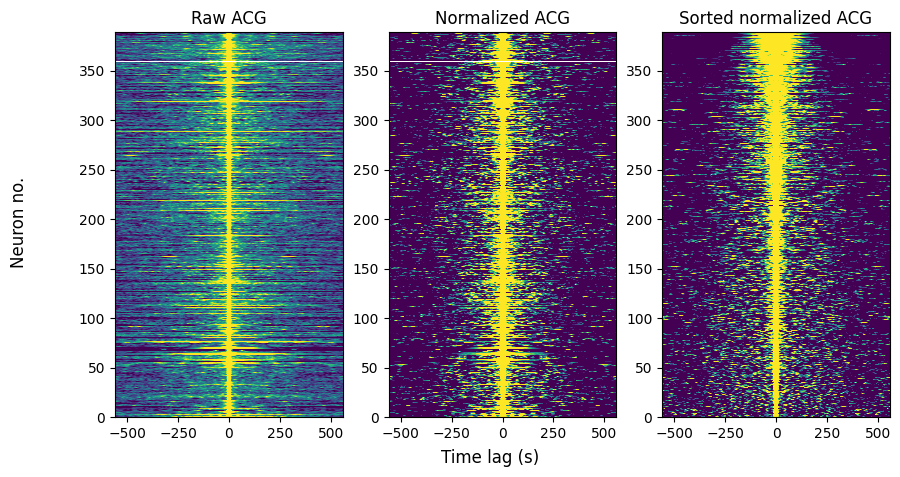

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(acorr.values.T, extent=(-560, 560, 0, len(acorr.keys())), interpolation='none', aspect='auto', vmin=0, vmax=3)
axes[0].set(title='Raw ACG')
axes[1].imshow(acorr_zscored.values.T, extent=(-560, 560, 0, len(acorr.keys())), interpolation='none', aspect='auto', vmin=0, vmax=1)
axes[1].set(title='Normalized ACG')
axes[2].imshow(acorr_sorted.values.T, extent=(-560, 560, 0, len(acorr.keys())), interpolation='none', aspect='auto', vmin=0, vmax=1)
axes[2].set(title='Sorted normalized ACG')

fig.supxlabel('Time lag (s)')
fig.supylabel('Neuron no.')

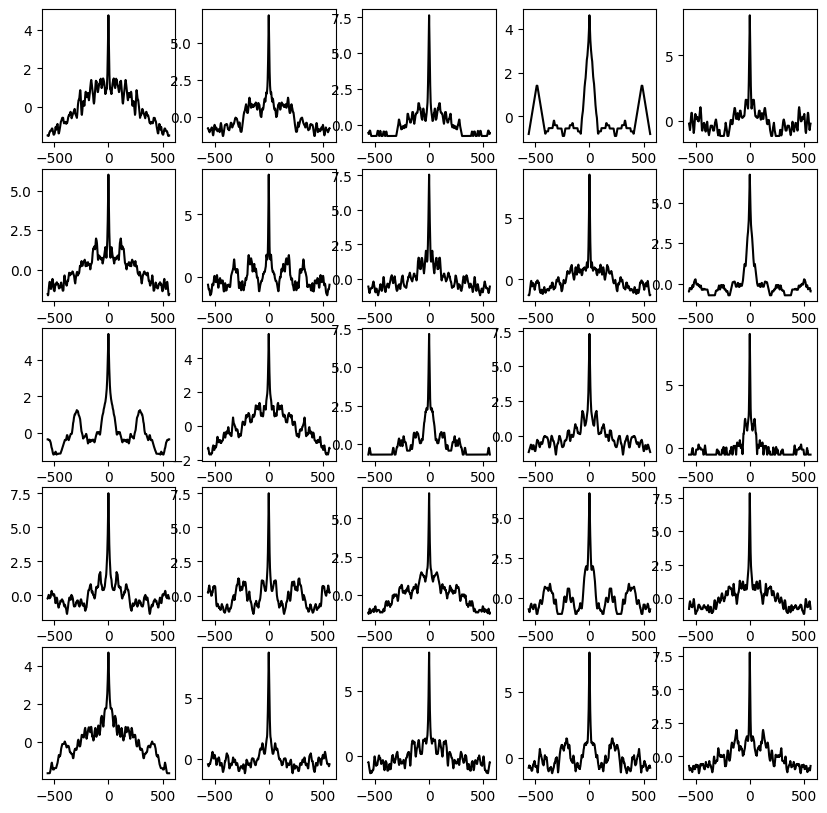

In [80]:
n = 3  # change to look at different subsets of neurons

fig, ax = plt.subplots(5, 5, figsize=(10,10))
axes = ax.flatten()
for i, a in enumerate(axes):
    a.plot(acorr_sorted.index, acorr_sorted.values.T[i + (25 * n),:], color='k')

##  Plot the power spectra

[Text(0.5, 1.0, 'PSD'),
 Text(0, 0.5, 'Unit no.'),
 Text(0.5, 0, 'Frequency (Hz)')]

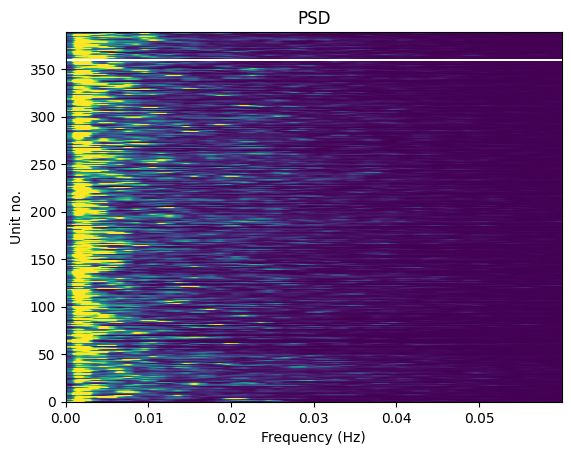

In [79]:
frequency_cutoff = 0.06
freq_bins = f[f < frequency_cutoff]

fig, axes = plt.subplots()
axes.imshow(Pxxs[:, f < frequency_cutoff], aspect='auto', extent=[f[0], freq_bins[-1], 0, np.shape(Pxxs)[0]],
           vmin=0, vmax=200)
axes.set(title='PSD', ylabel='Unit no.', xlabel='Frequency (Hz)')